# Example for use IQ modulation/demodulation and digitizer

### Author

Boris Nedyalkov, Quantum Computing Lab, IFAE, Barcelona

#### **In this notebook you will learn how to:**

* Import all the libraries one needs
* Set the working parameters of the machine
* Initialize the machine
* Create simple I and Q signals
* Download the signals to the Proteus
* Create a tasktable (sequences of pulses with triggers)
* Readout the signal
* Process the signal readout data

### Import some generic libraries

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import os

srcpath = os.path.realpath('../../SourceFiles')
sys.path.append(srcpath)

# These are the Tabor developers' libraries, they allow us to I/O interface with the Proteus
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst

### Import our homemade libraries

In [29]:
import initializers  # this library contains intialization functions for the Proteus 

import pulse_lib # this library contains all the types of pulses, one can add here a new type of pulse if needed
import tasks # this library contains all the types of basic tasks, new ones can be added if need arises
import readers # this library contains all the readout functions

import helpers # this library contains auxillary functions

### Set the parameters of the machine

In [30]:
SCLK = 2.25e9 # sampling clock rate of the generator (AWG) ## max value 9e9
DUC_INTERP = 1  ### the DUC interpolator mode
DIG_SCLK = 2.25e9 # sampling clock rate of the digitizer (DAC) ## max value 2.7e9

SOURCE_NCO = 1e7   # The LO of the source/modulator
DDC_NCO = 1e7 # The LO of the demodulator (make ideally the same as Source NCO)

### Initialize the machine

In [31]:
# get the DAC mode, range, Serial port #, the data type of the system (8 or 16bit), and the instrument handle
dac_mode, max_dac, sid, data_type, inst = initializers.connection_func() # Make sure the Model name is P9484M, that the name of our module


=========CONNECTING=========
process id 12664
Connected to: Tabor Electronics,P9484M,000000220642,1.223.0
Model: P9484M
===CONNECTION ESTABLISHED===

===SYSTEM'S INFORMATION===
DAC waveform format: 16 bits-per-point
Max DAC wave-point level: 65535
Half DAC wave-point level: 32767.0
Number of channels: 4
Max segment number: 65536
Available memory per DDR: 8,581,545,984 wave-bytes
==========READY============


### Initialize the channels

In [32]:
# initialize channel 1
channel_numb = 1
initializers.initialization_func(channel_numb, inst, SCLK)

# # initialize all the channels
# for i in range(0,4):  
#     channel_numb = i + 1
#     initializers.initialization_func(channel_numb, inst, SCLK) 


===INITIALIZATION OF CHANNEL 1===  -->  ===DONE===
ERRORS: 0, no error


### Call the pulse library

In [33]:
pulse = pulse_lib.Pulse(SCLK, DUC_INTERP, show_plot = True)

##TEST IQ with simple square signals (I = 1, Q = 0)

In [34]:
##### TEST IQ
I = np.linspace (1,1,10000)   # just I = 1
Q = I*0                       # and 

inter_array = np.empty(len(I) + len(Q))
for i in range(0, len(I)):
    inter_array[0+i*2] = I[i]
    inter_array[1+i*2] = Q[i]
    
inter_array = helpers.digital_conv_func(inter_array, max_dac, data_type)

### Downloading some wave shapes onto the Proteus

In [35]:
wave1 = inter_array

In [36]:
# # initialize the channel
# channel_numb = 1
# initializers.initialization_func(channel_numb, inst, SCLK)

In [37]:
initializers.initialization_func_IQ(channel_numb, inst, SCLK, SOURCE_NCO)

@ When we download the signal onto the proteus we choose a segment number to assign to it, by this number we will refer to the signal later.

In [38]:
# download signal to an approprate 'channel' and 'segment of the channel'
helpers.download_func (inst, wave1, channel = 1, segment = 1)

wave size: 20000
0, no error


### Let us now define a tasktable (as sequence of pulses and actions)

In [39]:
task = tasks.Task(inst)

In [40]:
channel = 1
segment_number = 1

# this task table makes: 1 trigger, followed by one pulse
# the trigger is used to signal to the digitizer when to start capturing data
task.solid_task(inst, channel, segment_number)
helpers.start_task(inst, channel)

0, no error
0, no error


In [41]:
# in case we need some time delay b/w the trigger and the start of data capturing 
time_delay=0
readers.digitizer_setup(inst, DIG_SCLK, DDC_NCO, time_delay)

0, no error
0
0

0, no error
0, no error
0, no error


In [42]:
# define the number of frames and their length in data points for the capture of the signal
# here we will just use one frame
# but for 1000 separate measurments, one may want to use 1000 frames
numframes, framelen = 1, 10*4800
readers.framer(inst, numframes, framelen)

0
0, no error
X16


# DSP Setup

This is yet to be implemented (ask Joan about it)

In [43]:
# # Select to store the IQ data
# inst.send_scpi_cmd(':DSP:STOR1 DIRect1')
# resp = inst.send_scpi_query(':SYST:ERR?')
# print(resp)

# # Set IQ PATH Input to AMPH
# inst.send_scpi_cmd(':DSP:DEC:IQP:SEL 1')
# resp = inst.send_scpi_query(':SYST:ERR?')
# print(resp)

# inst.send_scpi_cmd(':DSP:DEC:IQP:INP AMPH')
# resp = inst.send_scpi_query(':SYST:ERR?')
# print(resp)

# # Set Decision frame size 50 points
# inst.send_scpi_cmd(':DSP:DEC:FRAM {0}'.format(50))
# resp = inst.send_scpi_query(':SYST:ERR?')
# print(resp)

In [44]:
# here we read the data on the INPUT of the devices and store it
readers.capturer(inst)

Response: 1,1,0,1 Time: 0.01
0, no error


In [45]:
# get the I and Q component of the signal
wave_i, wave_q = readers.IQ_data_extractor(inst, channel, numframes, framelen)

Total size in bytes: 192000

0, no error


In [46]:
wave_i

array([ 9204, 14437, 16201, ...,  5157, 11364, 15206])

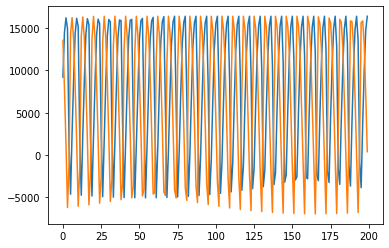

In [47]:
plt.plot(wave_i[0:200], '-', wave_q[0:200], '-')

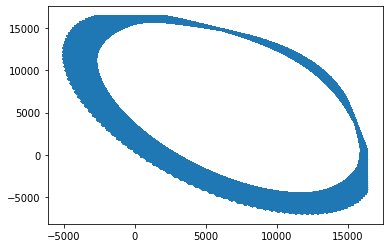

In [49]:
plt.plot (wave_i, wave_q)

### Sequence to close the instrument

In [ ]:
admin = TepAdmin()  ### decalring a shortcut to send SCPY commands to the machine
inst = admin.open_instrument(slot_id=sid)  ### decalring a shortcut to send SCPY commands to the machine

inst.close_instrument()
admin.close_inst_admin()